In [ ]:
!pip install tensorflow_io

import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

testing_wav_file_name = tf.keras.utils.get_file('miaow_16k.wav',
                                                'https://storage.googleapis.com/audioset/miaow_16k.wav',
                                                cache_dir='./',
                                                cache_subdir='test_data')

print(testing_wav_file_name)

motocycle_wav_file_name = tf.keras.utils.get_file('motocycle.wav',
                                                  'https://storage.googleapis.com/audioset/yamalyzer/audio/motorcycle.wav',
                                                  cache_dir='./',
                                                  cache_subdir='test_data')

print(motocycle_wav_file_name)

./test_data/miaow_16k.wav
1728512/1721868 [==============================] - 0s 0us/step
./test_data/motocycle.wav


In [ ]:
# Utility functions for loading audio files and making sure the sample rate is correct.

@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

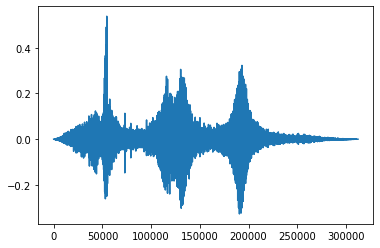

In [ ]:
testing_wav_data = load_wav_16k_mono(motocycle_wav_file_name)

_ = plt.plot(testing_wav_data)

# Play the audio file.
display.Audio(testing_wav_data,rate=16000)

In [ ]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

for name in class_names[:20]:
  print(name)
print('...')

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
...


In [ ]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.argmax(class_scores)
inferred_class = class_names[top_class]

print(f'The main sound is: {inferred_class}')
print(f'The embeddings shape: {embeddings.shape}')

The main sound is: Vehicle
The embeddings shape: (40, 1024)


In [ ]:
_ = tf.keras.utils.get_file('esc-50.zip',
                        'https://github.com/karoldvl/ESC-50/archive/master.zip',
                        cache_dir='./',
                        cache_subdir='datasets',
                        extract=True)

645005312/Unknown - 40s 0us/step

In [ ]:
esc50_csv = './datasets/ESC-50-master/meta/esc50.csv'
base_data_path = './datasets/ESC-50-master/audio/'

pd_data = pd.read_csv(esc50_csv)
pd_data.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [ ]:
my_classes = ['engine', 'helicopter', 'car_horn']
map_class_to_id = {'engine':0, 'helicopter':1, 'car_horn':2}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]

class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

full_path = filtered_pd['filename'].apply(lambda row: os.path.join(base_data_path, row))
filtered_pd = filtered_pd.assign(filename=full_path)

filtered_pd.head(10)

,filename,fold,target,category,esc10,src_file,take
53,./datasets/ESC-50-master/audio/1-17124-A-43.wav,1,2,car_horn,False,17124,A
55,./datasets/ESC-50-master/audio/1-172649-A-40.wav,1,1,helicopter,True,172649,A
56,./datasets/ESC-50-master/audio/1-172649-B-40.wav,1,1,helicopter,True,172649,B
57,./datasets/ESC-50-master/audio/1-172649-C-40.wav,1,1,helicopter,True,172649,C
58,./datasets/ESC-50-master/audio/1-172649-D-40.wav,1,1,helicopter,True,172649,D
59,./datasets/ESC-50-master/audio/1-172649-E-40.wav,1,1,helicopter,True,172649,E
60,./datasets/ESC-50-master/audio/1-172649-F-40.wav,1,1,helicopter,True,172649,F
72,./datasets/ESC-50-master/audio/1-181071-A-40.wav,1,1,helicopter,True,181071,A
73,./datasets/ESC-50-master/audio/1-181071-B-40.wav,1,1,helicopter,True,181071,B
74,./datasets/ESC-50-master/audio/1-18527-A-44.wav,1,0,engine,False,18527,A


In [ ]:
filenames = filtered_pd['filename']
targets = filtered_pd['target']
folds = filtered_pd['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
Total params: 526,339
Trainable params: 526,339
Non-trainable params: 0
_________________________________________________________________


In [ ]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [ ]:
history = my_model.fit(train_ds,
                       epochs=20,
                       validation_data=val_ds,
                       callbacks=callback)

Epoch 1/20
23/23 [==============================] - 10s 37ms/step - loss: 0.8715 - accuracy: 0.8194 - val_loss: 1.3181 - val_accuracy: 0.8208
Epoch 2/20
23/23 [==============================] - 1s 26ms/step - loss: 0.3520 - accuracy: 0.9181 - val_loss: 0.5220 - val_accuracy: 0.8208
Epoch 3/20
23/23 [==============================] - 1s 30ms/step - loss: 0.2560 - accuracy: 0.9278 - val_loss: 0.6931 - val_accuracy: 0.8250
Epoch 4/20
23/23 [==============================] - 1s 28ms/step - loss: 0.2106 - accuracy: 0.9472 - val_loss: 0.6197 - val_accuracy: 0.8250
Epoch 5/20
23/23 [==============================] - 1s 28ms/step - loss: 0.1624 - accuracy: 0.9736 - val_loss: 0.4862 - val_accuracy: 0.7792
Epoch 6/20
23/23 [==============================] - 1s 30ms/step - loss: 0.1890 - accuracy: 0.9681 - val_loss: 0.6723 - val_accuracy: 0.8042
Epoch 7/20
23/23 [==============================] - 1s 28ms/step - loss: 0.1413 - accuracy: 0.9722 - val_loss: 0.8161 - val_accuracy: 0.7917
Epoch 8/20
2

In [ ]:
loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

8/8 [==============================] - 1s 7ms/step - loss: 0.6698 - accuracy: 0.7875
Loss:  0.669760525226593
Accuracy:  0.7875000238418579


In [ ]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
result = my_model(embeddings).numpy()

inferred_class = my_classes[result.mean(axis=0).argmax()]
print(f'The main sound is: {inferred_class}')

The main sound is: engine
